#Import Libraries

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import torch

 **Fetching data from *Yahoo Finance***

In [6]:
data = yf.download("^IXIC", start="2015-01-01", end="2024-12-31", auto_adjust=False)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
Date,,,,,,
2015-01-02,4726.810059,4726.810059,4777.009766,4698.109863,4760.240234,1435150000
2015-01-05,4652.569824,4652.569824,4702.770020,4641.459961,4700.339844,1794470000
2015-01-06,4592.740234,4592.740234,4667.330078,4567.589844,4666.850098,2167320000
2015-01-07,4650.470215,4650.470215,4652.720215,4613.899902,4626.839844,1957950000
2015-01-08,4736.189941,4736.189941,4741.379883,4688.020020,4689.540039,2105450000


**Close price visualisation**

Text(0.5, 1.0, 'Close Price Visualization')

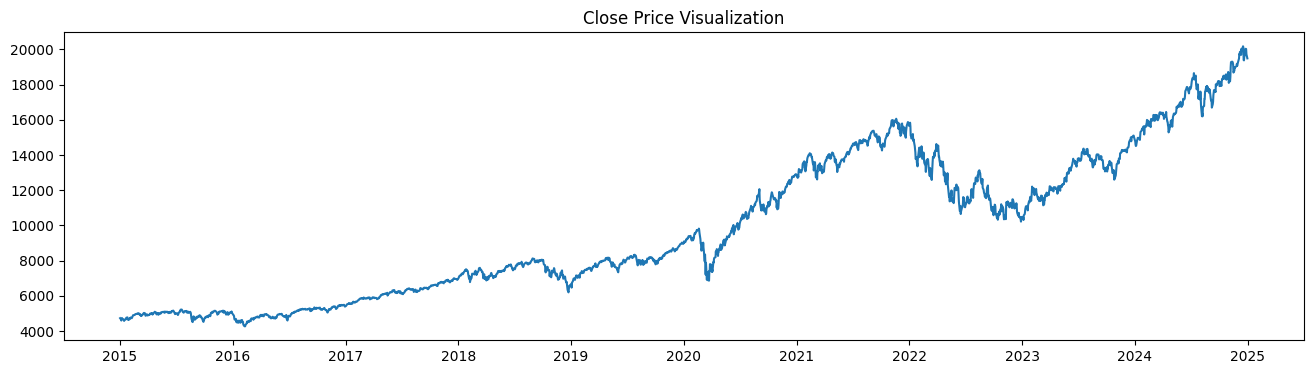

In [7]:
plt.figure(figsize = (16,4))
plt.plot(data.Close)
plt.title("Close Price Visualization")

# **Visualisation of moving average of 30/100 days**

Text(0.5, 1.0, 'Moving average of 30 days')

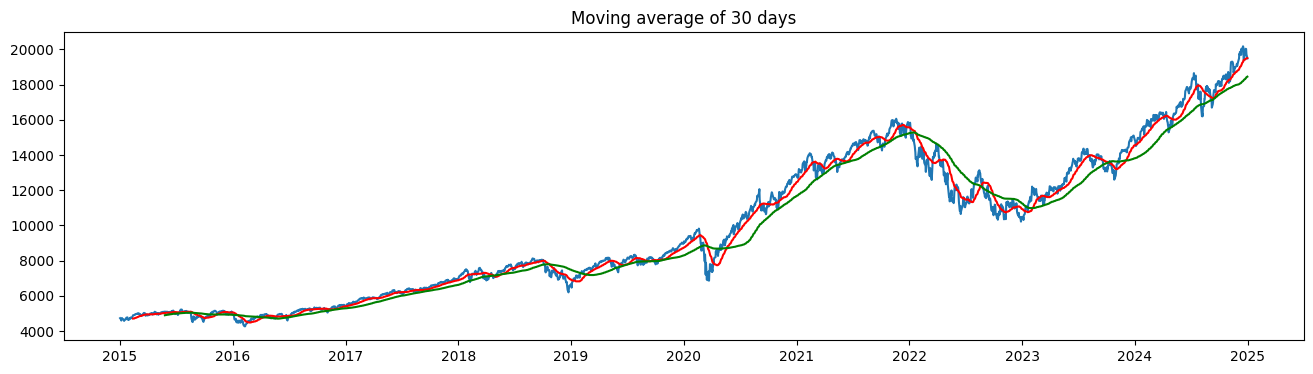

In [8]:
mov_avg30 = data.Close.rolling(30).mean() #Calculate the 30 day moving average
mov_avg100 = data.Close.rolling(100).mean() #Calculate the 100 day moving average
plt.figure(figsize = (16,4))
plt.plot(data['Adj Close'])
plt.plot(mov_avg30, 'r')
plt.plot(mov_avg100, 'g')
plt.title("Moving average of 30 days")

# Preprocessing the data

In [9]:
data['target'] = data['Adj Close']-data['Open'] #Set the target as the fluctuation of stock price in a day
data['target'] = data['target'].shift(-1)
data['target_class'] = data['target'].apply(lambda x: 1 if x > 0 else 0)
data['Nextclose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Date','Open','target' ,'High', 'Low', 'Close', 'Volume', ], axis=1, inplace=True)
data.head()

<ipython-input-9-3d08e5dbed74>:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop(['Date','Open','target' ,'High', 'Low', 'Close', 'Volume', ], axis=1, inplace=True)


Price,Adj Close,target_class,Nextclose
Ticker,^IXIC,,
0,4726.810059,0,4652.569824
1,4652.569824,0,4592.740234
2,4592.740234,1,4650.470215
3,4650.470215,1,4736.189941
4,4736.189941,0,4704.069824


# Scaling the data

In [10]:
X = data['Adj Close'].values  # Features (Adj Close)
y = data['Nextclose'].values  # Target (Nextclose)


**It is important to split the data before Scaling to avoid data leakage**

In [11]:
from sklearn.preprocessing import MinMaxScaler
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale train and test sets
scaler= MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))


# Create ans load Sequences

In [39]:
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Create the LSTM model

In [40]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=0.2)

        # Fc layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Cell state

        # LSTM forward pass
        output, _ = self.lstm(x, (h0, c0))


        output = self.fc(output[:, -1, :])  # Only last time step output
        return output

# Model hyperparameters
input_size = 1  # Adj Close
hidden_size = 64  # nmbr of LSTM neurons
num_layers = 2  # number of LSTM layers
output_size = 1  # Nextclose

# Instantiate model
model = LSTM(input_size, hidden_size, num_layers, output_size)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model


LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

# Training

In [45]:
from torch import optim
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("Training complete!")


Epoch [10/50], Loss: 0.004773
Epoch [20/50], Loss: 0.008372
Epoch [30/50], Loss: 0.005196
Epoch [40/50], Loss: 0.004573
Epoch [50/50], Loss: 0.005567
Training complete!


# Evaluation

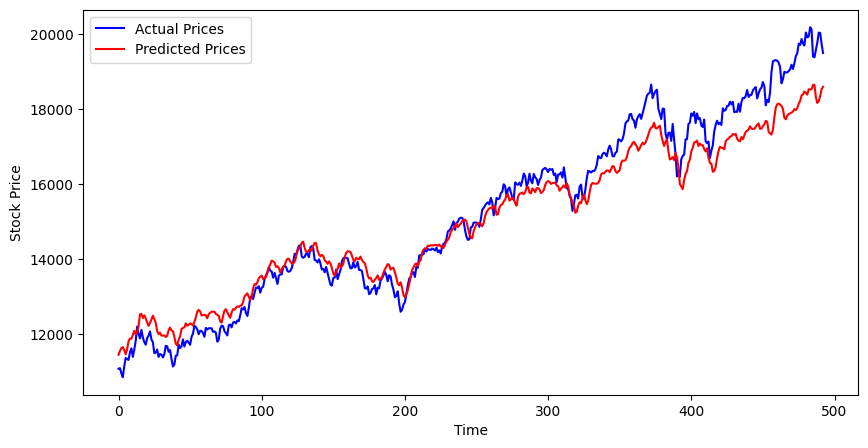

In [56]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

# Convert back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


#Accuracy

The **Mean absolute percentage erro**r formula is given by:


$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$



In [58]:
import numpy as np

def mean_absolute_percentage_error(y_actual, y_pred):
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

# Compute MAPE
mape = mean_absolute_percentage_error(actuals, predictions)
accuracy = 100 - mape  # Convert error to accuracy
accuracy

96.98192179203033